In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error as mse
from sklearn.utils import shuffle

sns.set(font_scale=1.5)

Исследуем зависимость качества предсказаний модели случайного леса в зависимости от различных гиперпараметров на примере задаче регрессии. Будем использовать класс `RandomForestRegressor` библиотеки `sklearn`.

В качестве данных возьмём датасет `california_housing` из библиотеки `sklearn` о стоимости недвижимости в различных округах Калифорнии. Этот датасет состоит из 20640 записей и содержит следующие признаки для каждого округа: `MedInc`, `HouseAge`, `AveRooms`, `AveBedrms`, `Population`, `AveOccup`, `Latitude`, `Longitude`. `HouseAge` и `Population` — целочисленные признаки. Остальные признаки — вещественные.

In [ ]:
housing = fetch_california_housing()
X, y = housing.data, housing.target

Разобъем данные на обучающую выборку и на валидацию, выделив на валидацию 25% данных.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=17
)

Посмотрим, как изменяется качество леса в зависимости от выбранных параметров. Для этого построим графики зависимости MSE на тестовой выборке от количества деревьев (от 1 до 100) и от максимальной глубины дерева (от 3 до 25)

In [ ]:
def plot_dependence_test(param_grid, test_values, param_label,
                         metrics_label, title):
    '''
    Функция для построения графиков зависимости целевой метрики
    от некоторого параметра модели на валидационной выборке.

    Параметры.
    1) param_grid — значения исследуемого параметра,
    2) test_values — значения метрики на валидационной выборке,
    3) param_label — названия параметра,
    4) metrics_label — название метрики,
    5) title — заголовок для графика.
    '''

    plt.figure(figsize=(12, 6))
    plt.plot(param_grid, test_values, label='test', linewidth=3)

    plt.xlabel(param_label)
    plt.ylabel(metrics_label)
    plt.legend()
    plt.title(title)
    plt.show()

Для построения зависимости от количества деревьев можно было бы построить модели для каждого количества деревьев, посчитать метрику и построить график. Однако лес — набор этих деревьев. Построив один лес, мы можем посчитать предсказания для каждого дерева в отдельности. Затем, усредняя, получаем предсказания для произвольного количества деревьев. Такой трюк позволяет экономить время проведения эксперимента.

In [ ]:
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

predictions_by_tree = np.array(
    [tree.predict(X_test) for tree in regressor.estimators_]
)

n_estimators_grid = np.arange(1, 101)
predictions = np.cumsum(predictions_by_tree, axis=0) \
                / n_estimators_grid[:, np.newaxis]
mse_values = [mse(y_test, p) for p in predictions]

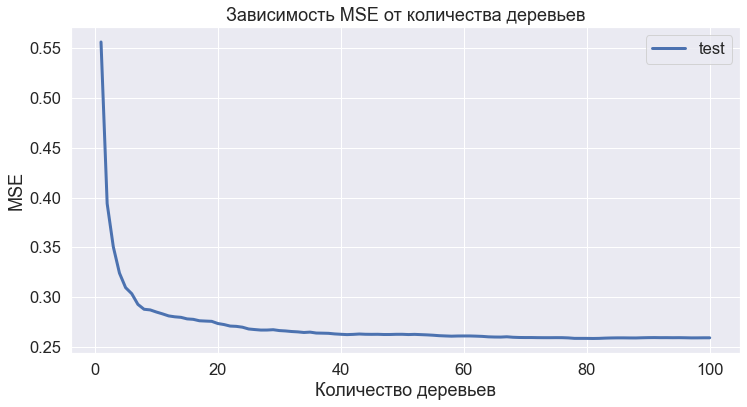

In [ ]:
plot_dependence_test(n_estimators_grid, mse_values,
                     'Количество деревьев', 'MSE',
                     'Зависимость MSE от количества деревьев')

In [ ]:
mse_values = []

for max_depth in tqdm(range(3, 25)):
    regressor = RandomForestRegressor(max_depth=max_depth,
                                      n_estimators=50, random_state=42)
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    mse_values.append(mse(y_test, predictions))

  0%|          | 0/22 [00:00<?, ?it/s]

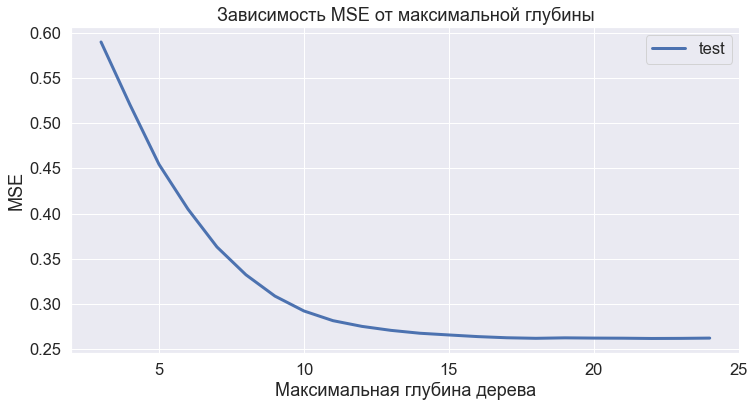

In [ ]:
plot_dependence_test(np.arange(3, 25), mse_values,
                     'Максимальная глубина дерева', 'MSE',
                     'Зависимость MSE от максимальной глубины')

Основываясь на полученных графиках, ответим на следующие вопросы.

1. Какие закономерности можно увидеть на построенных графиках? Почему графики получились такими?

2. Как изменяется качество предсказаний с увеличением исследуемых параметров, когда эти параметры уже достаточно большие.

3. В предыдущем задании вы на практике убедились, что решающее дерево начинает переобучаться при достаточно больших значениях максимальной глубины. Справедливо ли это утверждение для случайного леса?

**Вывод.**

По первому графику можно сделать вывод, что с возрастанием числа использованных деревьев MSE снижается. Но при достаточно больних значениях `n_estimators` значение MSE практически перестаёт меняться. С параметром `max_depth` ситуация аналогична. Случайный лес, в отличие от решающего дерева, гораздо менее склонен к переобучению при больших `max_depth`. Ведь использование большого количества деревьев снижает дисперсию предсказаний, а использование больших значений `max_depth` или вообще отсутствие ограничения на максимальную глубину позволяет строить модели, близкие к несмещенным, предсказания которых имеют большую дисперсию. В итоге случайный лес как комбинация большого количества глубоких деревьев имеет маленькое смещение (bias) и маленькую дисперсию.

Обучим случайный лес с параметрами по умолчанию и выведите MSE на тестовой выборке.

Проведем
эксперимент 3 раза. Почему результаты отличаются? Какие источники случайности есть при построении
случайного леса и какие из них реализуются в данном случае?

In [ ]:
for iteration in tqdm(range(3)):
    regressor = RandomForestRegressor(n_estimators=100)
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    print('MSE = {:.4f}'.format(mse(y_test, predictions)))

  0%|          | 0/3 [00:00<?, ?it/s]

MSE = 0.2614
MSE = 0.2598
MSE = 0.2594


**Ответ.** Потому что лес случайный. Он основан на `n_estimators` случайных деревьях, которые могут очень сильно отличаться друг от друга.

Источники случайности:
1. Бутстрепированные выборки.
2. Выделение множества признаков для поиска оптимального разбиения в каждой вершине.

В модели по умолчанию используются все признаки, поэтому второго фактора случайности в нашем случае нет.

Было бы неплохо определиться с тем, какое количество деревьев нужно использовать и какой максимальной глубины они будут. Подберите оптимальные значения `max_depth` и `n_estimators` с помощью кросс-валидации.

In [ ]:
rf_gridsearch = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions={
        'max_depth': [None] + np.arange(3, 31).tolist(),
        'n_estimators': np.arange(25, 401)
    },
    scoring='neg_mean_squared_error',  # оптимизируемый скор
    cv=5,  # разбиение выборки на 5 фолдов
    verbose=1,  # насколько часто печатать сообщения
    n_jobs=-2,  # кол-во параллельных процессов
    n_iter=100,  # кол-во итераций случайного выбора гиперпараметров
    random_state=0  # seed для фиксации генератора случайных чисел
)

In [ ]:
rf_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-2,
                   param_distributions={'max_depth': [None, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30],
                                        'n_estimators': array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,...
       324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
       337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
       350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
       363

In [ ]:
print(rf_gridsearch.best_params_)

{'n_estimators': 226, 'max_depth': 26}


Зафиксируем эти оптимальные значения параметров и в дальнейшем будем их использовать.

In [ ]:
max_depth = rf_gridsearch.best_params_['max_depth']
n_estimators = rf_gridsearch.best_params_['n_estimators']

Оценим качество предсказаний обученного решающего леса.

In [ ]:
predictions = rf_gridsearch.best_estimator_.predict(X_test)
print('{:.4f}'.format(mse(y_test, predictions)))

0.2578


Исследуем зависимость метрики `mse` от количества признаков, по которым происходит разбиение в вершине дерева. Поскольку количество признаков в датасете не очень большое (их 8), то можно перебрать все возможные варианты количества признаков, использующихся при разбиении вершин.

In [ ]:
mse_train_values = []
mse_test_values = []

for n_features in tqdm(range(1, 9)):
    rf_regressor = RandomForestRegressor(
        max_depth=max_depth, n_estimators=n_estimators,
        max_features=n_features, random_state=42
    )
    rf_regressor.fit(X_train, y_train)

    current_train_mse = mse(y_train, rf_regressor.predict(X_train))
    current_test_mse = mse(y_test, rf_regressor.predict(X_test))
    print('n_features: {}, train_mse: {:.4f}, test_mse: {:.4f}'.format(
        n_features, current_train_mse, current_test_mse
    ))

    mse_train_values.append(current_train_mse)
    mse_test_values.append(current_test_mse)

  0%|          | 0/8 [00:00<?, ?it/s]

n_features: 1, train_mse: 0.0389, test_mse: 0.2902
n_features: 2, train_mse: 0.0327, test_mse: 0.2513
n_features: 3, train_mse: 0.0324, test_mse: 0.2488
n_features: 4, train_mse: 0.0329, test_mse: 0.2509
n_features: 5, train_mse: 0.0336, test_mse: 0.2557
n_features: 6, train_mse: 0.0337, test_mse: 0.2564
n_features: 7, train_mse: 0.0339, test_mse: 0.2578
n_features: 8, train_mse: 0.0341, test_mse: 0.2578


Построим график зависимости метрики mse на `test` и `train` в зависимости от числа признаков, использующихся при разбиении в каждой вершине.

In [ ]:
def plot_dependence(param_grid, train_values, test_values,
                    param_label='', metrics_label='', title='',
                    train_label='train (RandomForest)',
                    test_label='test (RandomForest)',
                    create_figure=True):
    '''
    Функция для построения графиков зависимости целевой метрики
    от некоторого параметра модели на обучающей и на валидационной
    выборке.

    Параметры.
    1) param_grid — значения исследуемого параметра,
    2) train_values — значения метрики на обучающей выборке,
    3) test_values — значения метрики на валидационной выборке,
    4) param_label — названия параметра,
    5) metrics_label — название метрики,
    6) title — заголовок для графика,
    7) create_figure — флаг, устанавливающий нужно ли создавать
    новую фигуру для графика.
    '''

    if create_figure:
        plt.figure(figsize=(12, 6))
    plt.plot(param_grid, train_values, label=train_label, linewidth=3)
    plt.plot(param_grid, test_values, label=test_label, linewidth=3)

    plt.legend()
    if create_figure:
        plt.xlabel(param_label)
        plt.ylabel(metrics_label)
        plt.title(title, fontsize=20)

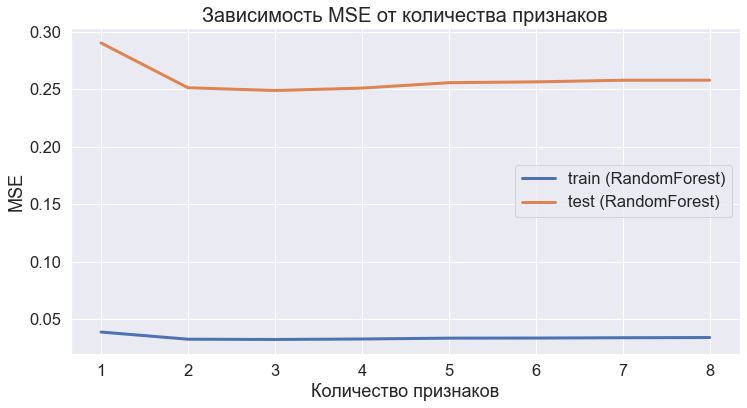

In [ ]:
plot_dependence(range(1, 9), mse_train_values, mse_test_values,
                'Количество признаков', 'MSE',
                'Зависимость MSE от количества признаков')

**Вывод.**

Как можно заметить по графику, оптимальное число признаков для тестовой выборки равно 3, а для обучающей выборки ошибка практически не меняется с увеличением количества признаков. Значит, действительно не всегда стоит выбирать при каждом разбиении вершины из всех признаков, поскольку это может привести к переобучению.
При этом, при увеличении значения `n_features` деревья в случайном лесу становятся всё более похожими друг на друга и их попарная корреляция увеличивается. При этом, если взять значение `n_features` равным количеству признаков в датасете, то в каждой вершине деревья будут оптимизировать значения одинакового функционала, выбирая признак из одинакового множества признаков, и останется единственный фактор случайности — бутсрепированная выборка, которая может меняться у разных деревьев.

Проведем эксперимент, в котором выясним, как изменится качество регрессии, если набор признаков, по которым происходит разбиение в каждой вершине определяется не заново в каждой вершине, а задан заранее для всего дерева (то есть перед каждым построением дерева выбирается новый набор признаков, который будет рассматриваться при построении всех разбиений в этом дереве).

Построим графики `mse` на обучающей и на валидационной выборке в зависимости от числа рассматриваемых признаков в дереве.

In [ ]:
simple_mse_train_values = []
simple_mse_test_values = []

for n_features in tqdm(range(1, 9)):
    rf_regressor = BaggingRegressor(
        base_estimator=DecisionTreeRegressor(
            max_depth=max_depth
        ),
        random_state=42,
        max_features=n_features,
        n_estimators=100
    )

    rf_regressor.fit(X_train, y_train)
    current_train_mse = mse(y_train, rf_regressor.predict(X_train))
    current_test_mse = mse(y_test, rf_regressor.predict(X_test))
    print('n_features: {}, train_mse: {:.4f}, test_mse: {:.4f}'.format(
          n_features, current_train_mse, current_test_mse))

    simple_mse_train_values.append(current_train_mse)
    simple_mse_test_values.append(current_test_mse)

  0%|          | 0/8 [00:00<?, ?it/s]

n_features: 1, train_mse: 0.5031, test_mse: 0.9386
n_features: 2, train_mse: 0.1287, test_mse: 0.6545
n_features: 3, train_mse: 0.0656, test_mse: 0.4415
n_features: 4, train_mse: 0.0439, test_mse: 0.3165
n_features: 5, train_mse: 0.0352, test_mse: 0.2630
n_features: 6, train_mse: 0.0316, test_mse: 0.2370
n_features: 7, train_mse: 0.0321, test_mse: 0.2393
n_features: 8, train_mse: 0.0352, test_mse: 0.2593


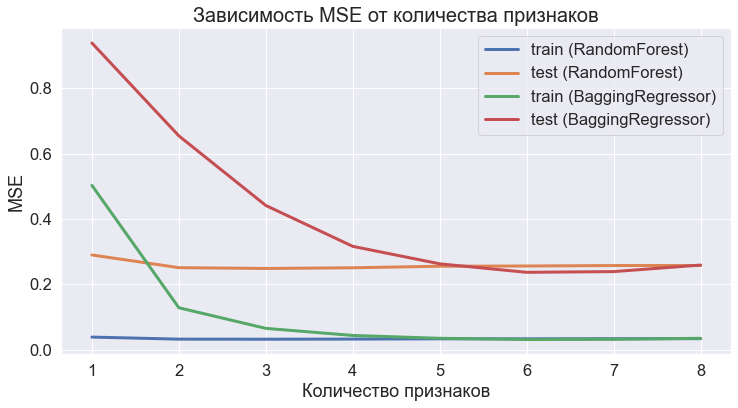

In [ ]:
plot_dependence(range(1, 9), mse_train_values, mse_test_values,
                'Количество признаков', 'MSE',
                'Зависимость MSE от количества признаков')
plot_dependence(range(1, 9), simple_mse_train_values,
                simple_mse_test_values,
                train_label='train (BaggingRegressor)',
                test_label='test (BaggingRegressor)',
                create_figure=False)

Сравним результаты обычного случайного леса с только что построенным лесом.

**Вывод.**

Почти всех экспериментах при фиксации набора признаков значение MSE стало больше, чем без фиксации признаков. Из этого можно сделать вывод, что фиксировать признаки заранее — не очень хорошая идея.
Действительно, если мы строим дерево таким образом, то мы, по сути, просто отказываемся от некоторых признаков и надеемся, что без них регрессия будет давать хороший результат. Из-за этого множество различных деревьев сужается. Значит, увеличится дисперсия предсказаний и, как следствие, MSE.

Поясним разницу между следующими конструкциями:

`BaggingRegressor(base_estimator=DecisionTreeRegressor(), max_features=n_features)`

`BaggingRegressor(base_estimator=DecisionTreeRegressor(max_features=n_features))`

1. Мы строим бэггинг на основе деревьев. При построении каждого дерева для него заранее случайно выбирается подмножество признаков размера `n_features`.
2. По сути случайный лес. При построении дерева при поиске оптимального разбиения в вершине выбирается случайное подмножество признаков размера n_features , среди которых ищется лучший порог.

Как мы уже выяснили, второй подход дает большее разнообразие деревьев и меньшее смещение. Что ведет к более хорошим результатам.

---
Почему случайный **лес**, а не **линейная регрессия**? (мини-обзор bias-variance)
---
---

**bias-variance**: Проведем эксперимент, в котором выясним, насколько уменьшается разброс (variance-компонента) беггинг-модели на 100 базовых моделях по отношению к одной базовой модели. Будем использовать данные из предыдущей задачи. Рассмотрим беггинг на следующих базовых моделях:
* решающие деревья
* ридж-регрессия

Для решения задачи потребуется оценить корреляции предсказаний на тестовой выборке базовых моделей, входящих в состав беггинг-модели.

Насколько уменьшается разброс в каждом случае? Для каждого случая построим также матрицу корреляций предсказаний базовых моделей и гистограмму по ним.

Обучим случайный лес и бэггинг над `Ridge`-регрессией.

In [ ]:
ridge_bagging = BaggingRegressor(
    base_estimator=Ridge(), n_estimators=100, random_state=42
).fit(X_train, y_train)
rf_regressor = RandomForestRegressor(
    n_estimators=100, random_state=42
).fit(X_train, y_train)

В качестве оценки коэффициента корреляции будем использовать коэффициент Пирсона. Он оценивает степень линейной зависимости между выборками.

RandomForestRegressor(random_state=42)


/tmp/ipykernel_201460/724110797.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


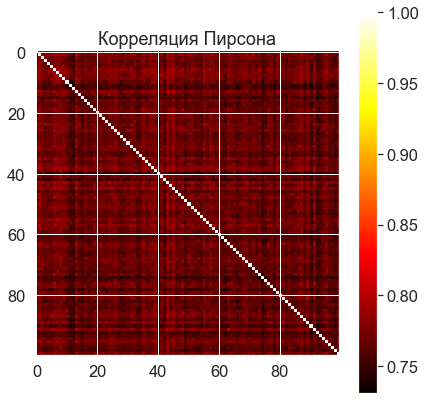

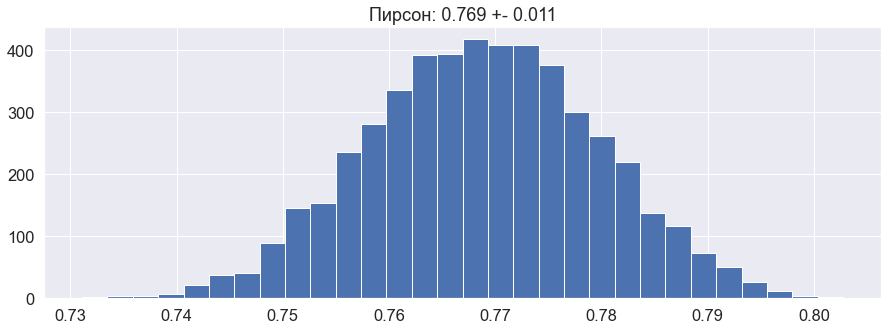

BaggingRegressor(base_estimator=Ridge(), n_estimators=100, random_state=42)


/tmp/ipykernel_201460/724110797.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


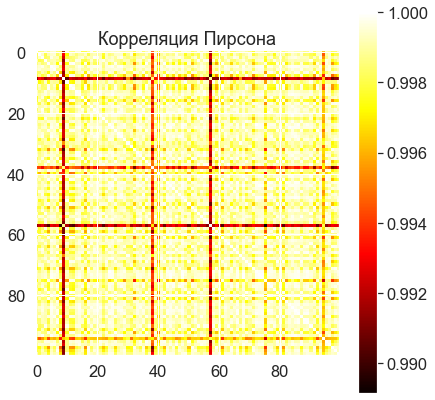

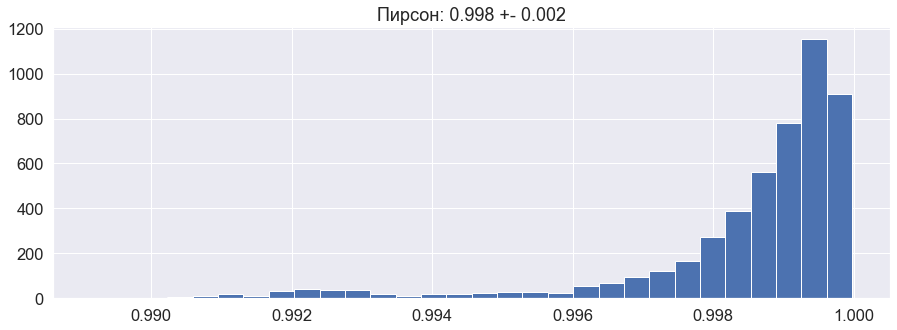

In [ ]:
for model in [rf_regressor, ridge_bagging]:
    print(model)

    predictions = [
        estimator.predict(X_test) for estimator in model.estimators_
    ]
    estimators_count = len(model.estimators_)

    pearson_matrix = np.zeros((estimators_count, estimators_count))
    for i in range(estimators_count):
        for j in range(i, estimators_count):
            pearson_matrix[i, j] = sps.pearsonr(predictions[i],
                                                predictions[j])[0]
            pearson_matrix[j, i] = pearson_matrix[i, j]

    # визуализируем полученные матрицы ковариаций
    plt.figure(figsize=(15, 7))
    plt.subplot(121)
    plt.imshow(pearson_matrix, interpolation='none', cmap='hot')
    plt.colorbar()
    plt.title('Корреляция Пирсона')
    plt.show()

    plt.figure(figsize=(15, 5))

    # построим гистограммы ковариаций
    plt.subplot(111)
    ravel_corr = pearson_matrix[np.tril_indices(100, k=-1)]
    plt.hist(ravel_corr, bins=30)
    plt.title('Пирсон: {:.3f} +- {:.3f}'.format(ravel_corr.mean(),
                                                ravel_corr.std()))
    plt.show()

Посчитаем разброс бэггинга над `Ridge`-регрессией.

In [ ]:
ridge_var = 1/100 + 99/100 * 0.998
print(ridge_var)

0.99802


Посчитаем разброс случайного леса.

In [ ]:
rf_var = 1/100 + 99/100 * 0.77
print(rf_var)

0.7723


Оценим, во сколько раз бэггинг уменьшил разброс предсказаний базовых моделей.

Для леса:

In [ ]:
1 / rf_var

1.2948336138806165

Для `Ridge`-регрессии:

In [ ]:
1 / ridge_var

1.001983928177792

**Вывод.**

Как мы видим, в обоих случаях разброc предсказаний уменьшился.

В случайном лесе базовые модели оказались менее коррелированными, чем в бэггинге над `Ridge`-регрессией, поэтому случайный лес сильнее уменьшает разброс. Это связано с тем, что в лесе деревья могут быть достаточно разнообразными в отличии от линейной регрессией.